# Wer sind die grossen Abwesenden in den Sitzungen

In [303]:
import requests
import pandas as pd
import time 
import datetime
from datetime import timedelta
import glob
import re
import PyPDF2

In [312]:
#Erstelle Start und Endpunkte für Suche
today = datetime.datetime.today().strftime('%d.%m.%Y')
start = '16.05.2018'
end = today
#Zapfe die Gemeinderat API an
url_protokolle = 'https://www.gemeinderat-zuerich.ch/api/Protokoll?datumVon='+start+'&datumBis='+end
response = requests.get(url_protokolle)
protokolle = response.json()
print(len(protokolle), 'wurden in diesem Zeitraum gefunden')

175 wurden in diesem Zeitraum gefunden


In [305]:
#Um die Protokolle herunterzuladen
#for protokoll in protokolle:
    #url = 'https://www.gemeinderat-zuerich.ch/DocumentLoader.aspx?Typ=protokoll&ID='+str(protokoll['Id'])+'&FileName='+protokoll['FileName']
    #r = requests.get(url, allow_redirects=True)
    #open('protokolle/'+protokoll['FileName'], 'wb').write(r.content)

In [306]:
#Um die Protokolle auszuwerten
data = []
for protokoll in protokolle:
    dic = {'file':'',
          'anwesend':'',
          'abwesende':''}
    
    #url = 'https://www.gemeinderat-zuerich.ch/DocumentLoader.aspx?Typ=protokoll&ID='+str(protokoll['Id'])+'&FileName='+protokoll['FileName']
    #r = requests.get(url, allow_redirects=True)
    #open('protokolle/'+protokoll['FileName'], 'wb').write(r.content)
    dic['file'] = 'protokolle/'+protokoll['FileName']
    pdfFileObj = open('protokolle/'+protokoll['FileName'], 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    pageObj = pdfReader.getPage(0)
    protokoll = pageObj.extractText()
    anwesend = protokoll.split('Anwesend:')[1]
    dic['anwesend'] = anwesend.split('Mitglieder')[0].strip().replace('\n', '')
    abwesend = protokoll.split('Abwesend:')[1].replace('\n', '')
    dic['abwesende'] = abwesend.split('Der Rat')[0].strip()
    data.append(dic)
df = pd.DataFrame(data)
df.head()

,file,anwesend,abwesende
0,protokolle/GR-Protokoll 20200129.089.pdf,119,"Përparim Avdili (FDP), Simone Brander (SP), An..."
1,protokolle/GR-Protokoll 20200129.088.pdf,120,"Simone Brander (SP), Susanne Brunner (SVP), An..."
2,protokolle/GR-Protokoll 20200122.087.pdf,117,"Marcel Bührig (Grüne), Dorothea Frei (SP), Gab..."
3,protokolle/GR-Protokoll 20200115.086.pdf,122,"Simone Brander (SP), Susanne Brunner (SVP), Dr..."
4,protokolle/GR-Protokoll 20200115.086 substanzi...,122,"Simone Brander (SP), Susanne Brunner (SVP), Dr..."


In [307]:
#Vakanzen erkennen
df['vakanz'] = df.abwesende.str.extract('(\d) Sitz[e]* vakant')
df['vakanz'][df['vakanz'].isna()] = 0
df['vakanz'] = df['vakanz'].astype(int)
df['anwesend'] = df['anwesend'].astype(int) 
df['abwesende_count'] = 125-df['vakanz']-df['anwesend']

5.5 Räte fehlen im Schnitt. (Start: 16.05.2018 End: 05.02.2020)


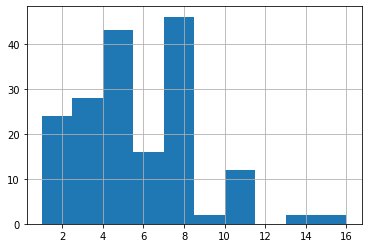

In [308]:
df['abwesende_count'].hist()
print(round(df['abwesende_count'].mean(),1), 'Räte fehlen im Schnitt. (Start: '+start+' End: '+today+')')

In [309]:
def get_missing(row):
    missinglist = row['abwesende'].split(', ')
    return missinglist

In [310]:
missings = []
for sitzung in df.apply(get_missing, axis=1):
    for missing in sitzung:
        missings.append(missing)
missings = pd.DataFrame(missings)
df_missings = missings[0].value_counts().reset_index()

In [311]:
df_missings.columns = ['name','count']
df_missings['protokolle'] = len(protokolle)
df_missings['share'] = round(df_missings['count']/df_missings['protokolle']*100,1)
df_missings.head(20)

,name,count,protokolle,share
0,Dr. Urs Egger (FDP),32,175,18.3
1,Thomas Schwendener (SVP),32,175,18.3
2,Martin Götzl (SVP),28,175,16.0
3,Maria del Carmen Señorán (SVP),26,175,14.9
4,Andri Silberschmidt (FDP),26,175,14.9
5,Marcel Müller (FDP),23,175,13.1
6,Roger Tognella (FDP),23,175,13.1
7,Susanne Brunner (SVP),23,175,13.1
8,Peter Anderegg (EVP),22,175,12.6
9,Samuel Balsiger (SVP),20,175,11.4
